In [8]:
import pandas as pd
import matplotlib.pyplot as plt

## Import and Prepare Weather Data

In [9]:
# Import Weather Data
weather_path = "/Users/loso/code/projects/forecast-and-flex/data/raw/weather_hourly_darksky.csv"
weather = pd.read_csv(weather_path)

In [10]:
# Change date column to datetime and set as index
weather['time'] = pd.to_datetime(weather['time'])
weather = weather.sort_values('time')
weather = weather.set_index('time')

## Importing and Processing Energy Data

In [28]:
# Importing Energy Data (all meters in block_0)
energy_path = "/Users/loso/code/projects/forecast-and-flex/data/raw/halfhourly_dataset/halfhourly_dataset/block_0.csv"
energy = pd.read_csv(energy_path, parse_dates=["tstp"])

meter_ids = sorted(energy["LCLid"].dropna().unique())
print(f"meters in block_0: {len(meter_ids)}")

meters in block_0: 50


In [29]:
# Dropping null values + aggregate all meters to one series
energy["energy(kWh/hh)"] = (
    energy["energy(kWh/hh)"].replace("Null", 0)
)
energy["energy(kWh/hh)"] = (
    pd.to_numeric(energy["energy(kWh/hh)"], errors="coerce")
    .fillna(0)
)

In [ ]:
#Set date as index and lock values for 2013
energy_2013 = energy.loc[
    (energy["tstp"] >= "2013-01-01") &
    (energy["tstp"] <= "2013-12-31 23:30:00")
].copy()

energy_2013 = (
    energy_2013
    .groupby("tstp", as_index=True)["energy(kWh/hh)"]
    .mean()
    .to_frame()
    .asfreq("30T")
)

/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/1075094878.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .asfreq("30T")


## Matching the format weather and energy data timeframes

In [31]:
weather_2013 = weather.loc['2013-01-01':'2013-12-31 23:00:00'].copy()
weather_2013 = weather_2013.asfreq('H')
weather_2013 = weather_2013.interpolate('time').ffill().bfill()

weather_30m = weather_2013.asfreq('30T')
weather_30m = weather_30m.interpolate('time').ffill().bfill()

/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/4277471527.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_2013 = weather_2013.asfreq('H')
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/4277471527.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_2013 = weather_2013.interpolate('time').ffill().bfill()
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/4277471527.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_30m = weather_2013.asfreq('30T')
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/4277471527.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interp

## Merge Weather Data into Energy Data

In [32]:
data = energy_2013[['energy(kWh/hh)']].join(weather_30m, how='inner')

In [33]:
data = data.drop(columns=['apparentTemperature', 'humidity', 'pressure', 'visibility', 'dewPoint', 'windBearing', 'precipType', 'icon', 'summary'])

In [35]:
data

,energy(kWh/hh),temperature,windSpeed
2013-01-01 00:00:00,0.486667,7.010,5.460
2013-01-01 00:30:00,0.415812,7.250,5.485
2013-01-01 01:00:00,0.413187,7.490,5.510
2013-01-01 01:30:00,0.363208,7.325,5.625
2013-01-01 02:00:00,0.356292,7.160,5.740
...,...,...,...
2013-12-31 21:00:00,0.743864,5.920,4.380
2013-12-31 21:30:00,0.690432,6.230,4.640
2013-12-31 22:00:00,0.609477,6.540,4.900
2013-12-31 22:30:00,0.545682,6.985,5.180


In [36]:
# is weekend indicator
data["is_weekend"] = data.index.weekday >= 5
data["is_weekend"] = data["is_weekend"].astype(int)

# Season indicators
month = data.index.month
data["spring"] = month.isin([3, 4, 5]).astype(int)
data["summer"] = month.isin([6, 7, 8]).astype(int)
data["autumn"] = month.isin([9, 10, 11]).astype(int)

## Load in Bank Holiday Data

In [37]:
bank_hols = ['2013-12-26','2013-12-25','2013-08-26','2013-05-27','2013-06-05','2013-01-04','2013-03-29','2013-01-01']

In [38]:
data['is_bank_hol'] = data.index.isin(bank_hols)
data['is_bank_hol'] = data['is_bank_hol'].astype(int)

/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_11732/1871912212.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data['is_bank_hol'] = data.index.isin(bank_hols)


## When clusters are ready add to features

## For now continue

In [39]:
data

,energy(kWh/hh),temperature,windSpeed,is_weekend,spring,summer,autumn,is_bank_hol
2013-01-01 00:00:00,0.486667,7.010,5.460,0,0,0,0,1
2013-01-01 00:30:00,0.415812,7.250,5.485,0,0,0,0,0
2013-01-01 01:00:00,0.413187,7.490,5.510,0,0,0,0,0
2013-01-01 01:30:00,0.363208,7.325,5.625,0,0,0,0,0
2013-01-01 02:00:00,0.356292,7.160,5.740,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2013-12-31 21:00:00,0.743864,5.920,4.380,0,0,0,0,0
2013-12-31 21:30:00,0.690432,6.230,4.640,0,0,0,0,0
2013-12-31 22:00:00,0.609477,6.540,4.900,0,0,0,0,0
2013-12-31 22:30:00,0.545682,6.985,5.180,0,0,0,0,0


In [40]:
# assumes df has a datetime column named 'date' and target 'Energy'
target_col = "energy(kWh/hh)"
exog_cols = [c for c in data.columns if c != target_col]  # other features
y = data[target_col]
exog = data[exog_cols] if exog_cols else None

In [41]:
split_idx = int(len(data) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
exog_train = exog.iloc[:split_idx] if exog is not None else None
exog_test = exog.iloc[split_idx:] if exog is not None else None

In [42]:
import statsmodels.api as sm

order = (1, 1, 1)              # simple ARMA
seasonal_order = (0, 1, 1, 48) # daily seasonality

sarimax_model = sm.tsa.statespace.SARIMAX(
    y_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_train,
    enforce_stationarity=True,
    enforce_invertibility=True,
    simple_differencing=False
)

results = sarimax_model.fit(
    method="lbfgs",
    maxiter=60,
    disp=False
)

results.summary()

/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     energy(kWh/hh)   No. Observations:                14015
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 48)   Log Likelihood               27045.386
Date:                            Fri, 19 Dec 2025   AIC                         -54068.773
Time:                                    17:10:52   BIC                         -53985.784
Sample:                                01-01-2013   HQIC                        -54041.142
                                     - 10-19-2013                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.0060      0.001    -10.370      0.000      -0.007      -0.005
windSpeed      -0.0002      0.001     -0.280      0.780      -0.002       0.001
is_weekend      0.0114      0.004      3.078      0.002       0.004       0.019
spring          0.0323      0.013      2.401      0.016       0.006       0.059
summer         -0.1129      0.016     -7.088      0.000      -0.144      -0.082
autumn         -0.0046      0.019     -0.243      0.808      -0.042       0.033
is_bank_hol     0.0574      0.009      6.152      0.000       0.039       0.076
ar.L1           0.6568      0.007     88.562      0.000       0.642       0.671
ma.L1          -0.9431      0.004   -245.601      0.000      -0.951      -0.936
ma.S.L48       -0.9169      0.003   -290.416      0.000      -0.923      -0.911
sigma2          0.0012   1.14e-05    106.686      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  19.46   Jarque-Bera (JB):              1252.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
pred = results.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = pred.predicted_mean
conf_int = pred.conf_int()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
print("MAE", mean_absolute_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2", r2_score(y_test, y_pred))

MAE 0.0693959750817611
RMSE 0.09366007362013681
R2 0.7124997467543273


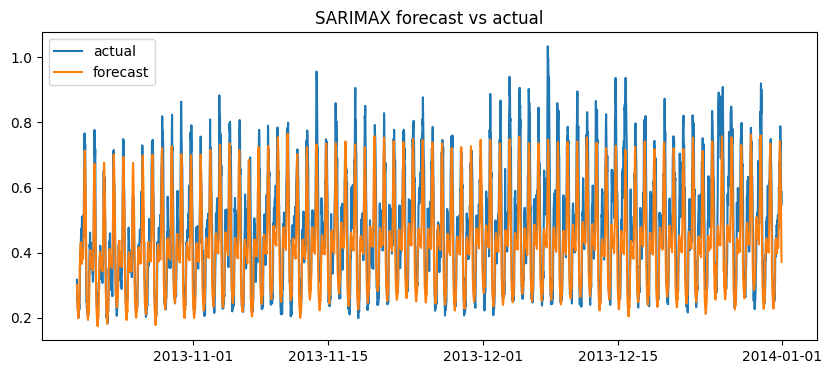

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="actual")
plt.plot(y_test.index, y_pred, label="forecast")
# plt.fill_between(y_test.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
#                 color="gray", alpha=0.2, label="conf int")
plt.legend()
plt.title("SARIMAX forecast vs actual")
plt.show()

### plot monthly forecasts

In [ ]:
# Build a monthly dataframe for plotting
plot_df = (
    pd.DataFrame({"actual": y_test, "forecast": y_pred})
    .dropna()
)
plot_df["month"] = plot_df.index.month

In [58]:
plot_df['month'].value_counts()

month
12    1487
11    1440
10     577
Name: count, dtype: int64

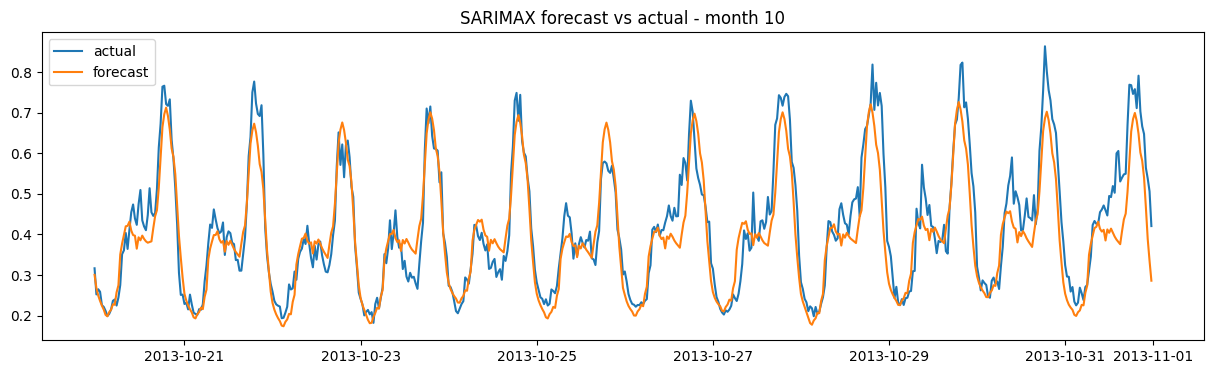

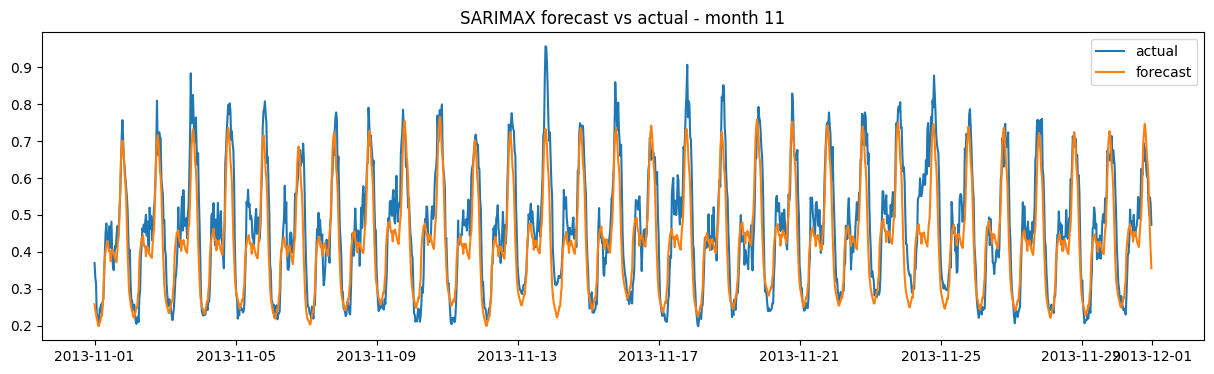

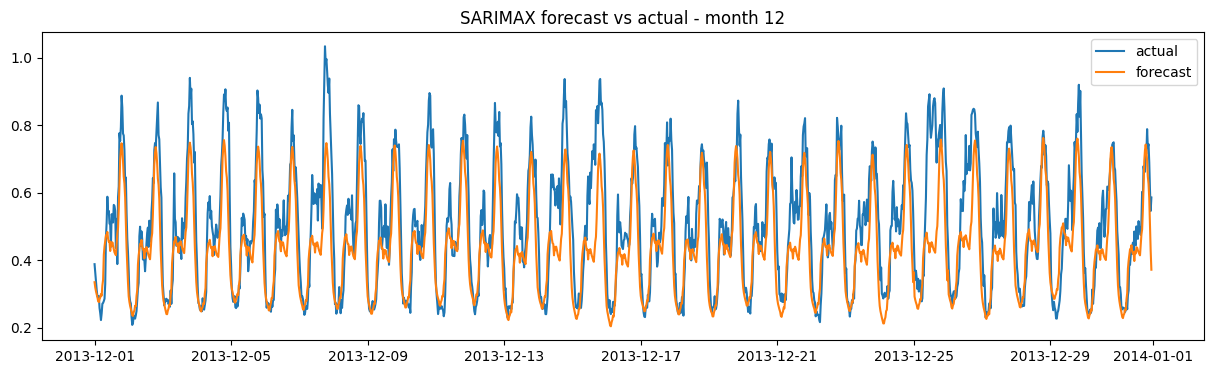

In [55]:
for m in range(1, 13):
      month_df = plot_df[plot_df["month"] == m]
      if month_df.empty:
          continue
      plt.figure(figsize=(15, 4))
      plt.plot(month_df.index, month_df["actual"], label="actual")
      plt.plot(month_df.index, month_df["forecast"], label="forecast")
      plt.title(f"SARIMAX forecast vs actual - month {m:02d}")
      plt.legend()
      plt.show()

In [59]:
next_steps = 48  # one day ahead in half-hours
future_exog = exog.iloc[-next_steps:]  # reuse last day of exog or supply future exog if you have it
future_forecast = results.get_forecast(steps=next_steps, exog=future_exog)
next_day_halfhourly = future_forecast.predicted_mean
print("Next day total Energy:", next_day_halfhourly.sum())
print("Per half-hour forecast head:\n", next_day_halfhourly.head())

Next day total Energy: 20.596491907234757
Per half-hour forecast head:
 2013-10-19 23:30:00    0.333346
2013-10-20 00:00:00    0.301883
2013-10-20 00:30:00    0.281910
2013-10-20 01:00:00    0.267283
2013-10-20 01:30:00    0.255373
Freq: 30min, Name: predicted_mean, dtype: float64


In [60]:
import pickle

In [61]:
with open('forecast.pkl', 'wb') as f:
    pickle.dump(sarimax_model, f)

## Experiments to improve the model